# Week 2: Tackle Overfitting with Data Augmentation

Welcome to this assignment! As in the previous week, you will be using the famous `cats vs dogs` dataset to train a model that can classify images of dogs from images of cats. For this, you will create your own Convolutional Neural Network in Tensorflow and leverage Keras' image preprocessing utilities, more so this time around since Keras provides excellent support for augmenting image data.

You will also need to create the helper functions to move the images around the filesystem as you did last week, so if you need to refresh your memory with the `os` module be sure to take a look a the [docs](https://docs.python.org/3/library/os.html).

Let's get started!

_**NOTE:** To prevent errors from the autograder, please avoid editing or deleting non-graded cells in this notebook . Please only put your solutions in between the `### START CODE HERE` and `### END CODE HERE` code comments, and refrain from adding any new cells._

In [1]:
# grader-required-cell

import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt

from tensorflow.data import Dataset
from tensorflow.keras.optimizers import RMSprop

Download the dataset from its original source by running the cell below.

Note that the `zip` file that contains the images is unzipped under the `/tmp` directory.

In [2]:
# If the URL doesn't work, visit https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765
# And right click on the 'Download Manually' link to get a new URL to the dataset

# Note: This is a very large dataset and will take some time to download

!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2024-04-23 00:33:14--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.62.142.15, 2600:1407:3c00:158c::317f, 2600:1407:3c00:158e::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.62.142.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.67M   107MB/s    in 6.8s    

2024-04-23 00:33:21 (116 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824887076/824887076]



Now the images are stored within the `/tmp/PetImages` directory. There is a subdirectory for each class, so one for dogs and one for cats.

In [3]:
# grader-required-cell

source_path = '/tmp/PetImages'

source_path_dogs = os.path.join(source_path, 'Dog')
source_path_cats = os.path.join(source_path, 'Cat')

# Deletes all non-image files (there are two .db files bundled into the dataset)
!find /tmp/PetImages/ -type f ! -name "*.jpg" -exec rm {} +

# os.listdir returns a list containing all files under the given path
print(f"There are {len(os.listdir(source_path_dogs))} images of dogs.")
print(f"There are {len(os.listdir(source_path_cats))} images of cats.")

There are 12500 images of dogs.
There are 12500 images of cats.


**Expected Output:**

```
There are 12500 images of dogs.
There are 12500 images of cats.
```

You will need a directory for cats-v-dogs, and subdirectories for training
and validation. These in turn will need subdirectories for 'cats' and 'dogs'. To accomplish this, complete the `create_train_val_dirs` below:

In [4]:
# grader-required-cell

# Define root directory
root_dir = '/tmp/cats-v-dogs'

# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

# GRADED FUNCTION: create_train_val_dirs
def create_train_val_dirs(root_path):
  """
  Creates directories for the train and test sets

  Args:
    root_path (string) - the base directory path to create subdirectories from

  Returns:
    None
  """

  ### START CODE HERE

  # HINT:
  # Use os.makedirs to create your directories with intermediate subdirectories
  # Don't hardcode the paths. Use os.path.join to append the new directories to the root_path parameter

  for x in ['training', 'validation']:
    os.makedirs(os.path.join(root_dir, x))
    os.makedirs(os.path.join(root_dir, x, 'cats'))
    os.makedirs(os.path.join(root_dir, x, 'dogs'))


  ### END CODE HERE


try:
  create_train_val_dirs(root_path=root_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

In [5]:
# grader-required-cell

# Test your create_train_val_dirs function

for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/tmp/cats-v-dogs/training
/tmp/cats-v-dogs/validation
/tmp/cats-v-dogs/training/dogs
/tmp/cats-v-dogs/training/cats
/tmp/cats-v-dogs/validation/dogs
/tmp/cats-v-dogs/validation/cats


**Expected Output (directory order might vary):**

``` txt
/tmp/cats-v-dogs/training
/tmp/cats-v-dogs/validation
/tmp/cats-v-dogs/training/cats
/tmp/cats-v-dogs/training/dogs
/tmp/cats-v-dogs/validation/cats
/tmp/cats-v-dogs/validation/dogs

```

Code the `split_data` function which takes in the following arguments:
- SOURCE_DIR: directory containing the files

- TRAINING_DIR: directory that a portion of the files will be copied to (will be used for training)

- VALIDATION_DIR: directory that a portion of the files will be copied to (will be used for validation)

- SPLIT_SIZE: determines the portion of images used for training.

The files should be randomized, so that the training set is a random sample of the files, and the validation set is made up of the remaining files.

For example, if `SOURCE_DIR` is `PetImages/Cat`, and `SPLIT_SIZE` is .9 then 90% of the images in `PetImages/Cat` will be copied to the `TRAINING_DIR` directory
and 10% of the images will be copied to the `VALIDATION_DIR` directory.

All images should be checked before the copy, so if they have a zero file length, they will be omitted from the copying process. If this is the case then your function should print out a message such as `"filename is zero length, so ignoring."`. **You should perform this check before the split so that only non-zero images are considered when doing the actual split.**


Hints:

- `os.listdir(DIRECTORY)` returns a list with the contents of that directory.

- `os.path.getsize(PATH)` returns the size of the file

- `copyfile(source, destination)` copies a file from source to destination

- `random.sample(list, len(list))` shuffles a list

In [7]:
# grader-required-cell

# GRADED FUNCTION: split_data
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):
  """
  Splits the data into train and test sets

  Args:
    SOURCE_DIR (string): directory path containing the images
    TRAINING_DIR (string): directory path to be used for training
    VALIDATION_DIR (string): directory path to be used for validation
    SPLIT_SIZE (float): proportion of the dataset to be used for training

  Returns:
    None
  """
  ### START CODE HERE
  def _is_file_bigger_than_zero_b(path: str, fn: str) -> bool:
    if os.path.getsize(os.path.join(path, fn)) > 0:
      return True
    else:
      print(f'{fn} is zero length, so ignoring.')
      return False

  fns = [fn for fn in os.listdir(SOURCE_DIR) if _is_file_bigger_than_zero_b(SOURCE_DIR, fn)]

  debug = False

  if debug:
    print(fns)

  training_fns = random.sample(fns, int(SPLIT_SIZE * len(fns)))
  val_fns = [x for x in fns if x not in training_fns]

  for train_fn in training_fns:
    copyfile(os.path.join(SOURCE_DIR, train_fn),
             os.path.join(TRAINING_DIR, train_fn))

  for val_fn in val_fns:
    copyfile(os.path.join(SOURCE_DIR, val_fn),
             os.path.join(VALIDATION_DIR, val_fn))


  ### END CODE HERE

In [8]:
# grader-required-cell

# Test your split_data function

# Define paths
CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"

TRAINING_DIR = "/tmp/cats-v-dogs/training/"
VALIDATION_DIR = "/tmp/cats-v-dogs/validation/"

TRAINING_CATS_DIR = os.path.join(TRAINING_DIR, "cats/")
VALIDATION_CATS_DIR = os.path.join(VALIDATION_DIR, "cats/")

TRAINING_DOGS_DIR = os.path.join(TRAINING_DIR, "dogs/")
VALIDATION_DOGS_DIR = os.path.join(VALIDATION_DIR, "dogs/")

# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_CATS_DIR)) > 0:
  for file in os.scandir(TRAINING_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_DOGS_DIR)) > 0:
  for file in os.scandir(TRAINING_DOGS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_CATS_DIR)) > 0:
  for file in os.scandir(VALIDATION_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_DOGS_DIR)) > 0:
  for file in os.scandir(VALIDATION_DOGS_DIR):
    os.remove(file.path)

# Define proportion of images used for training
split_size = .9

# Run the function
# NOTE: Messages about zero length images should be printed out
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, VALIDATION_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, VALIDATION_DOGS_DIR, split_size)

# Your function should perform copies rather than moving images so original directories should contain unchanged images
print(f"\n\nOriginal cat's directory has {len(os.listdir(CAT_SOURCE_DIR))} images")
print(f"Original dog's directory has {len(os.listdir(DOG_SOURCE_DIR))} images\n")

# Training and validation splits. Check that the number of images matches the expected output.
print(f"There are {len(os.listdir(TRAINING_CATS_DIR))} images of cats for training")
print(f"There are {len(os.listdir(TRAINING_DOGS_DIR))} images of dogs for training")
print(f"There are {len(os.listdir(VALIDATION_CATS_DIR))} images of cats for validation")
print(f"There are {len(os.listdir(VALIDATION_DOGS_DIR))} images of dogs for validation")

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


Original cat's directory has 12500 images
Original dog's directory has 12500 images

There are 11249 images of cats for training
There are 11249 images of dogs for training
There are 1250 images of cats for validation
There are 1250 images of dogs for validation


**Expected Output:**

```
666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


Original cat's directory has 12500 images
Original dog's directory has 12500 images

There are 11249 images of cats for training
There are 11249 images of dogs for training
There are 1250 images of cats for validation
There are 1250 images of dogs for validation
```

Now that you have successfully organized the data in a way that can be easily fed to Keras' `ImageDataGenerator`, it is time for you to code the generators that will yield batches of images, both for training and validation. For this, complete the `train_val_generators` function below.

Something important to note is that the images in this dataset come in a variety of resolutions. Luckily, the `flow_from_directory` method allows you to standarize this by defining a tuple called `target_size` that will be used to convert each image to this target resolution. **For this exercise use a `target_size` of (150, 150)**.

In [16]:
# grader-required-cell

# GRADED FUNCTION: train_val_generators
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  """
  Creates the training and validation data generators

  Args:
    TRAINING_DIR (string): directory path containing the training images
    VALIDATION_DIR (string): directory path containing the testing/validation images

  Returns:
    train_generator, validation_generator - tuple containing the generators
  """
  ### START CODE HERE

  # Instantiate the ImageDataGenerator class (don't forget to set the arguments to augment the images)
  train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.1,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=64,
                                                      class_mode='binary',
                                                      target_size=(150, 150))

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  validation_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.1,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=64,
                                                                class_mode='binary',
                                                                target_size=(150, 150))
  ### END CODE HERE
  return train_generator, validation_generator

In [17]:
# grader-required-cell

# Test your generators
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


**Expected Output:**

```
Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
```


One last step before training is to define the architecture of the model that will be trained.

Complete the `create_model` function below which should return a Keras' `Sequential` model.

Aside from defining the architecture of the model, you should also compile it so make sure to use a `loss` function that is compatible with the `class_mode` you defined in the previous exercise, which should also be compatible with the output of your network. You can tell if they aren't compatible if you get an error during training.

**Note that you should use at least 3 convolution layers to achieve the desired performance.**

In [10]:
# grader-required-cell

# GRADED FUNCTION: create_model
def create_model():
  # DEFINE A KERAS MODEL TO CLASSIFY CATS V DOGS
  # USE AT LEAST 3 CONVOLUTION LAYERS

  ### START CODE HERE

  model = tf.keras.models.Sequential([
      tf.keras.Input(shape=(150,150,3)),
      # Note the input shape is the desired size of the image 300x300 with 3 bytes color
      # This is the first convolution
      tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2, 2),
      # The second convolution
      tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      # The third convolution
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      # The fourth convolution
      # tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      # tf.keras.layers.MaxPooling2D(2,2),
      # Flatten the results to feed into a DNN
      tf.keras.layers.Flatten(),
      # 512 neuron hidden layers
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dropout(0.4),
      # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])


  model.compile(loss='binary_crossentropy',
          optimizer=RMSprop(learning_rate=1e-4),
          metrics=['accuracy']
  )

  ### END CODE HERE

  return model

In [11]:
# Get the untrained model
model = create_model()

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 64)        0

Now it is time to train your model!

Note: You can ignore the `UserWarning: Possibly corrupt EXIF data.` warnings.

In [23]:
!mkdir -p "/gdrive"

In [25]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [27]:
!mkdir -p "/gdrive/MyDrive/variables"

In [28]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_checkpoint_callback = ModelCheckpoint(
    filepath='/gdrive/MyDrive/variables',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_freq="epoch")

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    # Define the correct function signature for on_epoch_end
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('accuracy') > 0.8
        :
            print("\nReached 99% accuracy so cancelling training!")

            # Stop training once the above condition is met
            self.model.stop_training = True

In [29]:
# Get the untrained model
model = create_model()

# Train the model
# Note that this may take some time.
%timeit
history = model.fit(train_generator,
                    epochs=50,
                    steps_per_epoch=22498 // 64,
                    verbose=1,
                    validation_data=validation_generator,
                    validation_steps=2500 // 64,
                    callbacks=[model_checkpoint_callback]
          )

Epoch 1/50
260/351 [=====================>........] - ETA: 38s - loss: 0.6786 - accuracy: 0.5665

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


351/351 [==============================] - 173s 489ms/step - loss: 0.6723 - accuracy: 0.5777 - val_loss: 0.6482 - val_accuracy: 0.6234
Epoch 2/50
212/351 [=================>............] - ETA: 59s - loss: 0.6419 - accuracy: 0.6250 

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


351/351 [==============================] - 171s 487ms/step - loss: 0.6367 - accuracy: 0.6329 - val_loss: 0.6104 - val_accuracy: 0.6771
Epoch 3/50
288/351 [=======================>......] - ETA: 26s - loss: 0.6101 - accuracy: 0.6634

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


351/351 [==============================] - 172s 489ms/step - loss: 0.6095 - accuracy: 0.6644 - val_loss: 0.5999 - val_accuracy: 0.6779
Epoch 4/50
280/351 [======================>.......] - ETA: 30s - loss: 0.5981 - accuracy: 0.6745

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


351/351 [==============================] - 170s 483ms/step - loss: 0.5964 - accuracy: 0.6761 - val_loss: 0.5992 - val_accuracy: 0.6687
Epoch 5/50
346/351 [============================>.] - ETA: 2s - loss: 0.5876 - accuracy: 0.6886

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


351/351 [==============================] - 171s 487ms/step - loss: 0.5873 - accuracy: 0.6886 - val_loss: 0.5860 - val_accuracy: 0.6899
Epoch 6/50
229/351 [==================>...........] - ETA: 53s - loss: 0.5783 - accuracy: 0.6923

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


351/351 [==============================] - 170s 484ms/step - loss: 0.5745 - accuracy: 0.6968 - val_loss: 0.5656 - val_accuracy: 0.7071
Epoch 7/50
228/351 [==================>...........] - ETA: 52s - loss: 0.5679 - accuracy: 0.7040

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


351/351 [==============================] - 166s 474ms/step - loss: 0.5702 - accuracy: 0.7015 - val_loss: 0.5684 - val_accuracy: 0.7067
Epoch 8/50
241/351 [===================>..........] - ETA: 47s - loss: 0.5658 - accuracy: 0.7038

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


351/351 [==============================] - 171s 488ms/step - loss: 0.5643 - accuracy: 0.7051 - val_loss: 0.5514 - val_accuracy: 0.7196
Epoch 9/50
150/351 [===========>..................] - ETA: 1:24 - loss: 0.5550 - accuracy: 0.7132

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


351/351 [==============================] - 172s 489ms/step - loss: 0.5574 - accuracy: 0.7120 - val_loss: 0.5556 - val_accuracy: 0.7131
Epoch 10/50
240/351 [===================>..........] - ETA: 47s - loss: 0.5566 - accuracy: 0.7134

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


351/351 [==============================] - 169s 482ms/step - loss: 0.5545 - accuracy: 0.7143 - val_loss: 0.5501 - val_accuracy: 0.7216
Epoch 11/50
  7/351 [..............................] - ETA: 2:09 - loss: 0.5572 - accuracy: 0.7299

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


351/351 [==============================] - 175s 500ms/step - loss: 0.5516 - accuracy: 0.7198 - val_loss: 0.5472 - val_accuracy: 0.7260
Epoch 12/50
164/351 [=============>................] - ETA: 1:19 - loss: 0.5503 - accuracy: 0.7242

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


351/351 [==============================] - 170s 483ms/step - loss: 0.5420 - accuracy: 0.7282 - val_loss: 0.5447 - val_accuracy: 0.7183
Epoch 13/50
 89/351 [======>.......................] - ETA: 1:49 - loss: 0.5464 - accuracy: 0.7242

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


351/351 [==============================] - 170s 484ms/step - loss: 0.5408 - accuracy: 0.7267 - val_loss: 0.5343 - val_accuracy: 0.7392
Epoch 14/50
185/351 [==============>...............] - ETA: 1:12 - loss: 0.5388 - accuracy: 0.7312

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


351/351 [==============================] - 173s 492ms/step - loss: 0.5331 - accuracy: 0.7341 - val_loss: 0.5180 - val_accuracy: 0.7476
Epoch 15/50
319/351 [==========================>...] - ETA: 13s - loss: 0.5293 - accuracy: 0.7371

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


351/351 [==============================] - 174s 496ms/step - loss: 0.5294 - accuracy: 0.7368 - val_loss: 0.5218 - val_accuracy: 0.7360
Epoch 16/50
100/351 [=======>......................] - ETA: 1:46 - loss: 0.5232 - accuracy: 0.7431

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


351/351 [==============================] - 168s 478ms/step - loss: 0.5266 - accuracy: 0.7384 - val_loss: 0.5123 - val_accuracy: 0.7428
Epoch 17/50
306/351 [=========================>....] - ETA: 19s - loss: 0.5238 - accuracy: 0.7402

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


351/351 [==============================] - 168s 480ms/step - loss: 0.5249 - accuracy: 0.7400 - val_loss: 0.5201 - val_accuracy: 0.7448
Epoch 18/50
346/351 [============================>.] - ETA: 2s - loss: 0.5168 - accuracy: 0.7439

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


351/351 [==============================] - 167s 475ms/step - loss: 0.5162 - accuracy: 0.7445 - val_loss: 0.5380 - val_accuracy: 0.7248
Epoch 19/50
 50/351 [===>..........................] - ETA: 2:10 - loss: 0.5084 - accuracy: 0.7461

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


351/351 [==============================] - 169s 480ms/step - loss: 0.5106 - accuracy: 0.7475 - val_loss: 0.5151 - val_accuracy: 0.7368
Epoch 20/50
219/351 [=================>............] - ETA: 56s - loss: 0.5080 - accuracy: 0.7488

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


351/351 [==============================] - 168s 478ms/step - loss: 0.5057 - accuracy: 0.7510 - val_loss: 0.4978 - val_accuracy: 0.7576
Epoch 21/50
196/351 [===============>..............] - ETA: 1:07 - loss: 0.5007 - accuracy: 0.7532

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


351/351 [==============================] - 169s 483ms/step - loss: 0.5016 - accuracy: 0.7555 - val_loss: 0.4970 - val_accuracy: 0.7616
Epoch 22/50
 71/351 [=====>........................] - ETA: 1:58 - loss: 0.4955 - accuracy: 0.7636

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


351/351 [==============================] - 173s 494ms/step - loss: 0.4953 - accuracy: 0.7584 - val_loss: 0.5031 - val_accuracy: 0.7468
Epoch 23/50
335/351 [===========================>..] - ETA: 6s - loss: 0.4929 - accuracy: 0.7605

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


351/351 [==============================] - 168s 480ms/step - loss: 0.4950 - accuracy: 0.7588 - val_loss: 0.5100 - val_accuracy: 0.7440
Epoch 24/50
130/351 [==========>...................] - ETA: 1:34 - loss: 0.4956 - accuracy: 0.7607

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


351/351 [==============================] - 171s 486ms/step - loss: 0.4963 - accuracy: 0.7592 - val_loss: 0.4772 - val_accuracy: 0.7692
Epoch 25/50
135/351 [==========>...................] - ETA: 1:31 - loss: 0.4902 - accuracy: 0.7586

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


351/351 [==============================] - 171s 487ms/step - loss: 0.4900 - accuracy: 0.7617 - val_loss: 0.4998 - val_accuracy: 0.7568
Epoch 26/50
233/351 [==================>...........] - ETA: 50s - loss: 0.4833 - accuracy: 0.7704

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


351/351 [==============================] - 173s 492ms/step - loss: 0.4852 - accuracy: 0.7683 - val_loss: 0.4783 - val_accuracy: 0.7772
Epoch 27/50
 20/351 [>.............................] - ETA: 2:07 - loss: 0.4657 - accuracy: 0.7758

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


351/351 [==============================] - 168s 479ms/step - loss: 0.4843 - accuracy: 0.7672 - val_loss: 0.4799 - val_accuracy: 0.7608
Epoch 28/50
176/351 [==============>...............] - ETA: 1:14 - loss: 0.4738 - accuracy: 0.7733

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


351/351 [==============================] - 172s 489ms/step - loss: 0.4777 - accuracy: 0.7702 - val_loss: 0.4810 - val_accuracy: 0.7652
Epoch 29/50
 33/351 [=>............................] - ETA: 2:14 - loss: 0.4769 - accuracy: 0.7779

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


351/351 [==============================] - 173s 492ms/step - loss: 0.4806 - accuracy: 0.7670 - val_loss: 0.4859 - val_accuracy: 0.7740
Epoch 30/50
 92/351 [======>.......................] - ETA: 1:51 - loss: 0.4836 - accuracy: 0.7724

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


351/351 [==============================] - 172s 490ms/step - loss: 0.4764 - accuracy: 0.7725 - val_loss: 0.4719 - val_accuracy: 0.7756
Epoch 31/50
176/351 [==============>...............] - ETA: 1:17 - loss: 0.4696 - accuracy: 0.7762

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


351/351 [==============================] - 174s 496ms/step - loss: 0.4678 - accuracy: 0.7787 - val_loss: 0.4644 - val_accuracy: 0.7736
Epoch 32/50
347/351 [============================>.] - ETA: 1s - loss: 0.4700 - accuracy: 0.7797

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


351/351 [==============================] - 171s 487ms/step - loss: 0.4701 - accuracy: 0.7794 - val_loss: 0.4784 - val_accuracy: 0.7672
Epoch 33/50
249/351 [====================>.........] - ETA: 44s - loss: 0.4744 - accuracy: 0.7744

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


351/351 [==============================] - 170s 483ms/step - loss: 0.4723 - accuracy: 0.7767 - val_loss: 0.4644 - val_accuracy: 0.7748
Epoch 34/50
  5/351 [..............................] - ETA: 2:14 - loss: 0.4944 - accuracy: 0.7375

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


351/351 [==============================] - 171s 488ms/step - loss: 0.4656 - accuracy: 0.7792 - val_loss: 0.4895 - val_accuracy: 0.7596
Epoch 35/50
 29/351 [=>............................] - ETA: 2:20 - loss: 0.4736 - accuracy: 0.7748

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


351/351 [==============================] - 173s 493ms/step - loss: 0.4649 - accuracy: 0.7799 - val_loss: 0.4531 - val_accuracy: 0.7857
Epoch 36/50
157/351 [============>.................] - ETA: 1:25 - loss: 0.4612 - accuracy: 0.7793

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


351/351 [==============================] - 171s 486ms/step - loss: 0.4627 - accuracy: 0.7827 - val_loss: 0.4632 - val_accuracy: 0.7849
Epoch 37/50
218/351 [=================>............] - ETA: 58s - loss: 0.4597 - accuracy: 0.7840

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


351/351 [==============================] - 174s 496ms/step - loss: 0.4594 - accuracy: 0.7822 - val_loss: 0.4597 - val_accuracy: 0.7821
Epoch 38/50
347/351 [============================>.] - ETA: 1s - loss: 0.4566 - accuracy: 0.7845

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


351/351 [==============================] - 173s 493ms/step - loss: 0.4562 - accuracy: 0.7850 - val_loss: 0.4635 - val_accuracy: 0.7776
Epoch 39/50
249/351 [====================>.........] - ETA: 44s - loss: 0.4499 - accuracy: 0.7910

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


351/351 [==============================] - 170s 486ms/step - loss: 0.4533 - accuracy: 0.7876 - val_loss: 0.4386 - val_accuracy: 0.8057
Epoch 40/50
 43/351 [==>...........................] - ETA: 2:11 - loss: 0.4691 - accuracy: 0.7802

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


351/351 [==============================] - 170s 483ms/step - loss: 0.4513 - accuracy: 0.7859 - val_loss: 0.4566 - val_accuracy: 0.7796
Epoch 41/50
140/351 [==========>...................] - ETA: 1:30 - loss: 0.4558 - accuracy: 0.7873

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


351/351 [==============================] - 173s 494ms/step - loss: 0.4520 - accuracy: 0.7882 - val_loss: 0.4522 - val_accuracy: 0.7865
Epoch 42/50
 97/351 [=======>......................] - ETA: 1:53 - loss: 0.4471 - accuracy: 0.7878

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


351/351 [==============================] - 174s 496ms/step - loss: 0.4506 - accuracy: 0.7884 - val_loss: 0.4361 - val_accuracy: 0.7965
Epoch 43/50
281/351 [=======================>......] - ETA: 30s - loss: 0.4478 - accuracy: 0.7931

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


351/351 [==============================] - 171s 486ms/step - loss: 0.4485 - accuracy: 0.7913 - val_loss: 0.4463 - val_accuracy: 0.7909
Epoch 44/50
227/351 [==================>...........] - ETA: 52s - loss: 0.4461 - accuracy: 0.7947

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


351/351 [==============================] - 172s 491ms/step - loss: 0.4425 - accuracy: 0.7964 - val_loss: 0.4497 - val_accuracy: 0.7885
Epoch 45/50
 24/351 [=>............................] - ETA: 2:24 - loss: 0.4376 - accuracy: 0.8027

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


351/351 [==============================] - 166s 472ms/step - loss: 0.4447 - accuracy: 0.7946 - val_loss: 0.4512 - val_accuracy: 0.7817
Epoch 46/50
 77/351 [=====>........................] - ETA: 2:00 - loss: 0.4523 - accuracy: 0.7845

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


351/351 [==============================] - 169s 481ms/step - loss: 0.4449 - accuracy: 0.7919 - val_loss: 0.4333 - val_accuracy: 0.8021
Epoch 47/50
291/351 [=======================>......] - ETA: 25s - loss: 0.4412 - accuracy: 0.7977

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


351/351 [==============================] - 171s 487ms/step - loss: 0.4406 - accuracy: 0.7971 - val_loss: 0.4328 - val_accuracy: 0.8021
Epoch 48/50
349/351 [============================>.] - ETA: 0s - loss: 0.4352 - accuracy: 0.7982

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


351/351 [==============================] - 176s 501ms/step - loss: 0.4347 - accuracy: 0.7986 - val_loss: 0.4344 - val_accuracy: 0.8049
Epoch 49/50
 83/351 [======>.......................] - ETA: 1:57 - loss: 0.4381 - accuracy: 0.7976

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


351/351 [==============================] - 170s 484ms/step - loss: 0.4367 - accuracy: 0.7995 - val_loss: 0.4758 - val_accuracy: 0.7728
Epoch 50/50
195/351 [===============>..............] - ETA: 1:07 - loss: 0.4410 - accuracy: 0.7979

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


351/351 [==============================] - 173s 491ms/step - loss: 0.4364 - accuracy: 0.7996 - val_loss: 0.4311 - val_accuracy: 0.7973


Once training has finished, you can run the following cell to check the training and validation accuracy achieved at the end of each epoch.

**To pass this assignment, your model should achieve a training and validation accuracy of at least 80% and the final testing accuracy should be either higher than the training one or have a 5% difference at maximum**. If your model didn't achieve these thresholds, try training again with a different model architecture, remember to use at least 3 convolutional layers or try tweaking the image augmentation process.

You might wonder why the training threshold to pass this assignment is significantly lower compared to last week's assignment. Image augmentation does help with overfitting but usually this comes at the expense of requiring more training time. To keep the training time reasonable, the same number of epochs as in the previous assignment are kept.

However, as an optional exercise you are encouraged to try training for more epochs and to achieve really good training and validation accuracies.

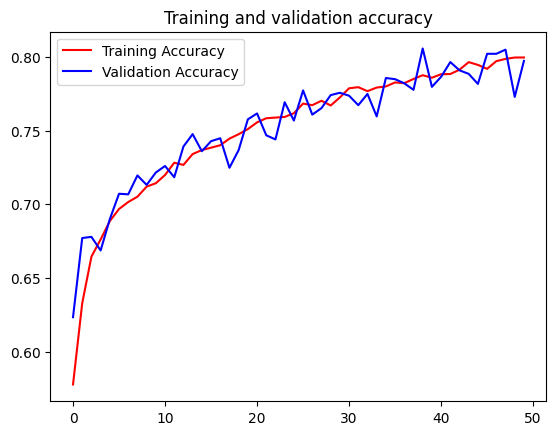

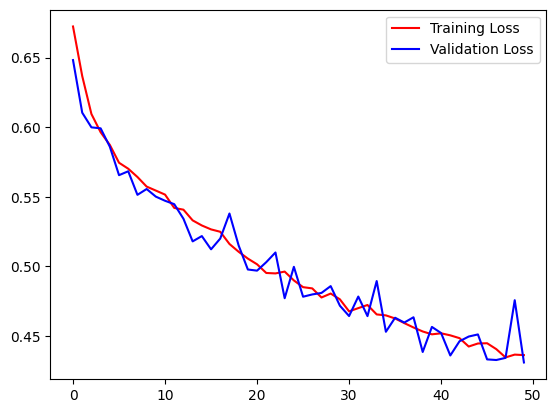

In [32]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.title('Training and validation accuracy')
plt.legend()
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend()
plt.show()

You will probably encounter that the model is overfitting, which means that it is doing a great job at classifying the images in the training set but struggles with new data. This is perfectly fine and you will learn how to mitigate this issue in the upcomming week.

Before closing the assignment, be sure to also download the `history.pkl` file which contains the information of the training history of your model. You can download this file by running the cell below:

In [33]:
def download_history():
  import pickle
  from google.colab import files

  with open('history_augmented.pkl', 'wb') as f:
    pickle.dump(history.history, f)

  files.download('history_augmented.pkl')

download_history()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Download your notebook for grading

Along with the `history.pkl` file, you will also need to submit your solution notebook for grading. The following code cells will check if this notebook's grader metadata (i.e. hidden data in the notebook needed for grading) is not modified by your workspace. This will ensure that the autograder can evaluate your code properly. Depending on its output, you will either:

* *if the metadata is intact*: Download the current notebook. Click on the File tab on the upper left corner of the screen then click on `Download -> Download .ipynb.` You can name it anything you want as long as it is a valid `.ipynb` (jupyter notebook) file.
<br>

* *if the metadata is missing*: A new notebook with your solutions will be created on this Colab workspace. It should be downloaded automatically and you can submit that to the grader.

In [34]:
# Download metadata checker
!wget -nc https://storage.googleapis.com/tensorflow-1-public/colab_metadata_checker.py

--2024-04-23 03:33:19--  https://storage.googleapis.com/tensorflow-1-public/colab_metadata_checker.py
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.214.207, 108.177.111.207, 142.250.1.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.214.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1997 (2.0K) [text/x-python-script]
Saving to: ‘colab_metadata_checker.py’

colab_metadata_chec 100%[===================>]   1.95K  --.-KB/s    in 0s      

2024-04-23 03:33:19 (39.0 MB/s) - ‘colab_metadata_checker.py’ saved [1997/1997]



In [35]:
import colab_metadata_checker

# Please see the output of this cell to see which file you need to submit to the grader
colab_metadata_checker.run('C2W2_Assignment_fixed.ipynb')

Grader metadata detected! You can download this notebook by clicking `File > Download > Download as .ipynb` and submit it to the grader!


**Please disregard the following note if the notebook metadata is detected**

_Note: Just in case the download fails for the second point above, you can also do these steps:_
* _Click the Folder icon on the left side of this screen to open the File Manager._
* _Click the Folder Refresh icon in the File Manager to see the latest files in the workspace. You should see a file ending with a `_fixed.ipynb`._
* _Right-click on that file to save locally and submit it to the grader._


**Congratulations on finishing this week's assignment!**

You have successfully implemented a convolutional neural network that classifies images of cats and dogs, along with the helper functions needed to pre-process the images!

**Keep it up!**